# Predicting the Survival of Titanic Passengers

In [454]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)

In [489]:
# Dataset

train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [456]:
test_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [457]:
train_raw.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [458]:
train_raw[train_raw['Age'].isna()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [459]:
# Drop NaN values from 'Embarked' column
train_raw.dropna(subset=['Embarked', 'Age'], inplace=True)

# One-hot encode 'Pclass' and 'Embarked' columns
train_encoded = pd.get_dummies(train_raw, columns=['Pclass', 'Embarked'], drop_first=True)

# Change 'Sex' column to 0 for male and 1 for female
train_encoded['Sex'] = train_encoded['Sex'].map({'male': 0, 'female': 1})

train_encoded.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,False,True,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,False,False,False,False
2,3,1,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,False,False,False,True
4,5,0,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,False,True,False,True


In [490]:
test_raw['Embarked'].fillna("Q", inplace=True)
test_raw['Age'].fillna("-1", inplace=True)

# One-hot encode 'Pclass' and 'Embarked' columns
test_encoded = pd.get_dummies(test_raw, columns=['Pclass', 'Embarked'], drop_first=True)

# Change 'Sex' column to 0 for male and 1 for female
test_encoded['Sex'] = test_encoded['Sex'].map({'male': 0, 'female': 1})

test_encoded.head()

/var/folders/14/9z1c81gx4nz56mqrm1tnqwy80000gn/T/ipykernel_39087/4105971376.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_raw['Embarked'].fillna("Q", inplace=True)
/var/folders/14/9z1c81gx4nz56mqrm1tnqwy80000gn/T/ipykernel_39087/4105971376.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

,PassengerId,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,892,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,False,True,True,False
1,893,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,False,True,False,True
2,894,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,True,False,True,False
3,895,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,False,True,False,True
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,False,True,False,True


In [461]:
train_encoded.describe()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,0.363764,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.481420,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,0.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,0.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,1.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,1.000000,80.000000,5.000000,6.000000,512.329200


In [462]:
test_encoded.describe()

,PassengerId,Sex,Age,SibSp,Parch,Fare
count,332.000000,332.000000,332.000000,332.000000,332.000000,331.000000
mean,1100.063253,0.382530,30.272590,0.481928,0.397590,40.982087
std,122.763173,0.486739,14.181209,0.874084,0.810651,61.228558
min,892.000000,0.000000,0.170000,0.000000,0.000000,0.000000
25%,992.750000,0.000000,21.000000,0.000000,0.000000,8.050000
50%,1099.500000,0.000000,27.000000,0.000000,0.000000,16.000000
75%,1210.250000,1.000000,39.000000,1.000000,1.000000,40.633350
max,1307.000000,1.000000,76.000000,8.000000,6.000000,512.329200


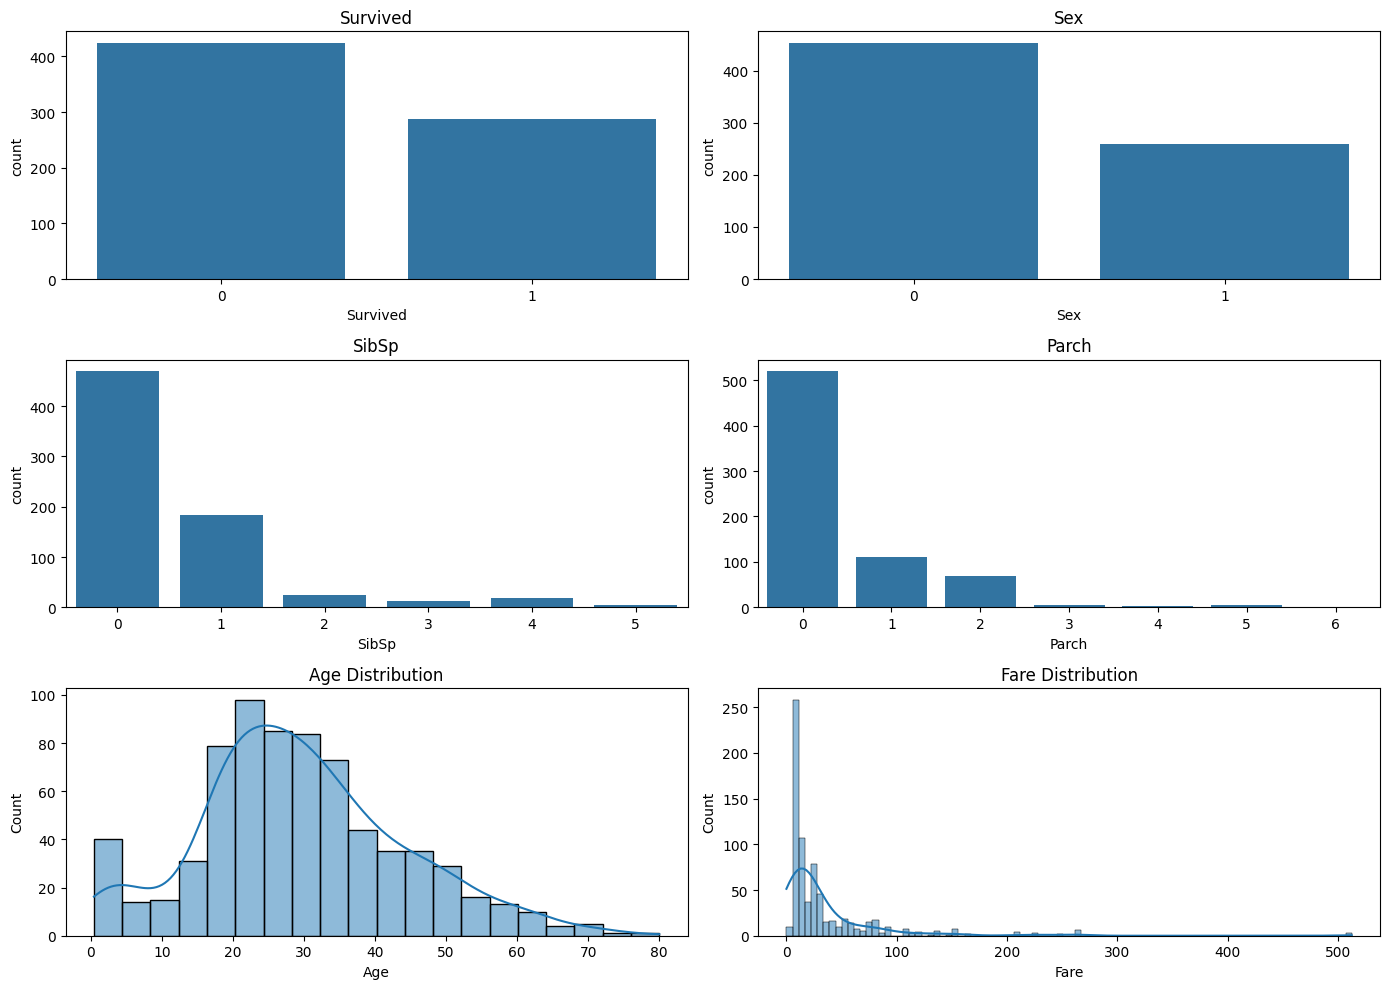

In [463]:
# Create a bar plot for 'Survived', 'Sex', 'SibSp', and 'Parch'
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

sns.countplot(ax=axes[0, 0], x='Survived', data=train_encoded)
axes[0, 0].set_title('Survived')

sns.countplot(ax=axes[0, 1], x='Sex', data=train_encoded)
axes[0, 1].set_title('Sex')

sns.countplot(ax=axes[1, 0], x='SibSp', data=train_encoded)
axes[1, 0].set_title('SibSp')

sns.countplot(ax=axes[1, 1], x='Parch', data=train_encoded)
axes[1, 1].set_title('Parch')

sns.histplot(ax=axes[2, 0], x='Age', data=train_encoded, kde=True)
axes[2, 0].set_title('Age Distribution')

sns.histplot(ax=axes[2, 1], x='Fare', data=train_encoded, kde=True)
axes[2, 1].set_title('Fare Distribution')

plt.tight_layout()
plt.show()

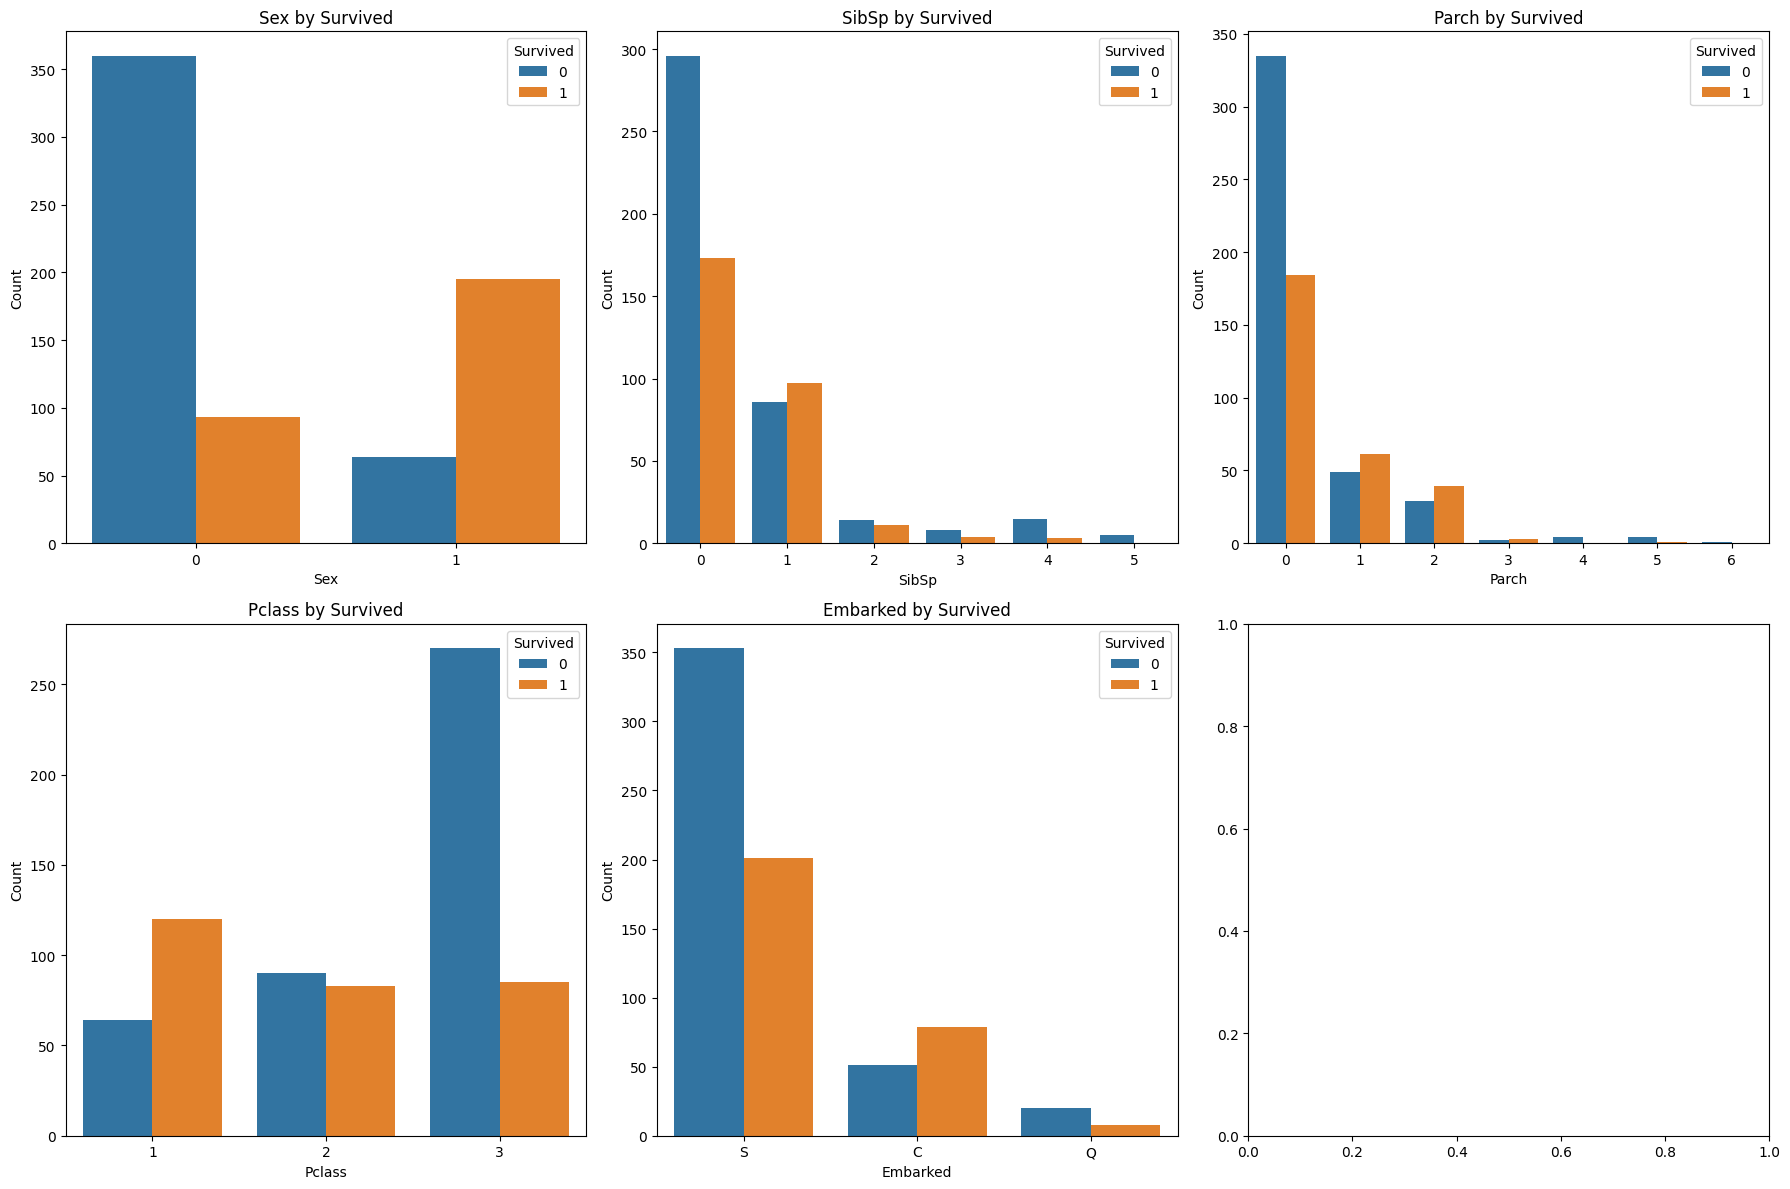

In [464]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Grouped barplot for 'Sex' by 'Survived'
sns.countplot(ax=axes[0, 0], x='Sex', hue='Survived', data=train_encoded)
axes[0, 0].set_title('Sex by Survived')
axes[0, 0].set_xlabel('Sex')
axes[0, 0].set_ylabel('Count')

# Grouped barplot for 'SibSp' by 'Survived'
sns.countplot(ax=axes[0, 1], x='SibSp', hue='Survived', data=train_encoded)
axes[0, 1].set_title('SibSp by Survived')
axes[0, 1].set_xlabel('SibSp')
axes[0, 1].set_ylabel('Count')

# Grouped barplot for 'Parch' by 'Survived'
sns.countplot(ax=axes[0, 2], x='Parch', hue='Survived', data=train_encoded)
axes[0, 2].set_title('Parch by Survived')
axes[0, 2].set_xlabel('Parch')
axes[0, 2].set_ylabel('Count')

# Grouped barplot for 'Pclass' by 'Survived'
sns.countplot(ax=axes[1, 0], x='Pclass', hue='Survived', data=train_raw)
axes[1, 0].set_title('Pclass by Survived')
axes[1, 0].set_xlabel('Pclass')
axes[1, 0].set_ylabel('Count')

# Grouped barplot for 'Embarked' by 'Survived'
sns.countplot(ax=axes[1, 1], x='Embarked', hue='Survived', data=train_raw)
axes[1, 1].set_title('Embarked by Survived')
axes[1, 1].set_xlabel('Embarked')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for Fare
sns.boxplot(ax=axes[0], x='Survived', y='Fare', data=train_encoded, color='orange')
axes[0].set_title('Fare by Survival')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Fare')

# Boxplot for Age
sns.boxplot(ax=axes[1], x='Survived', y='Age', data=train_encoded, color='orange')
axes[1].set_title('Age by Survival')
axes[1].set_xlabel('Survived')
axes[1].set_ylabel('Age')
plt.tight_layout()
plt.show()

In [465]:
pivot_table = train_raw.pivot_table(values=['Sex'], index='Pclass', columns='Survived', aggfunc='count')
print(pivot_table)

          Sex     
Survived    0    1
Pclass            
1          64  120
2          90   83
3         270   85


In [466]:
all_stats_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Basic Feature Selection

Based on the box plot, Fare and Age of those who survived and thos who did not seem to not differ significantly, hence, it is ruled out.

In [467]:
# Select features and target variable
X = train_encoded.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Survived', 'Name'])
y = train_encoded['Survived']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (534, 9)
X_test shape: (178, 9)
y_train shape: (534,)
y_test shape: (178,)


## Resampling

In [468]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print the shape of the resampled data
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")

X_train_resampled shape: (650, 9)
y_train_resampled shape: (650,)


## Logistics Regression

In [469]:
from sklearn.linear_model import LogisticRegression

# Initialize and fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_log = log_reg.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81        99
           1       0.77      0.76      0.76        79

    accuracy                           0.79       178
   macro avg       0.79      0.79      0.79       178
weighted avg       0.79      0.79      0.79       178



In [470]:
# Print the coefficients of the logistic regression model
feature_names = X_train_resampled.columns
log_reg_coefficients = log_reg.coef_[0]

# Create a DataFrame to display the feature names and their corresponding coefficients
log_reg_features = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg_coefficients
})

# Compute the increase in probability
log_reg_features['Increase in Probability'] = log_reg_features['Coefficient'].apply(lambda x: 1 / (1 + np.exp(-x)) - 0.5)

print(log_reg_features)

      Feature  Coefficient  Increase in Probability
0         Sex     2.184263                 0.398827
1         Age    -0.037727                -0.009431
2       SibSp    -0.454307                -0.111663
3       Parch    -0.166989                -0.041651
4        Fare     0.008376                 0.002094
5    Pclass_2    -0.531045                -0.129727
6    Pclass_3    -1.668194                -0.341335
7  Embarked_Q     0.103276                 0.025796
8  Embarked_S     0.035428                 0.008856


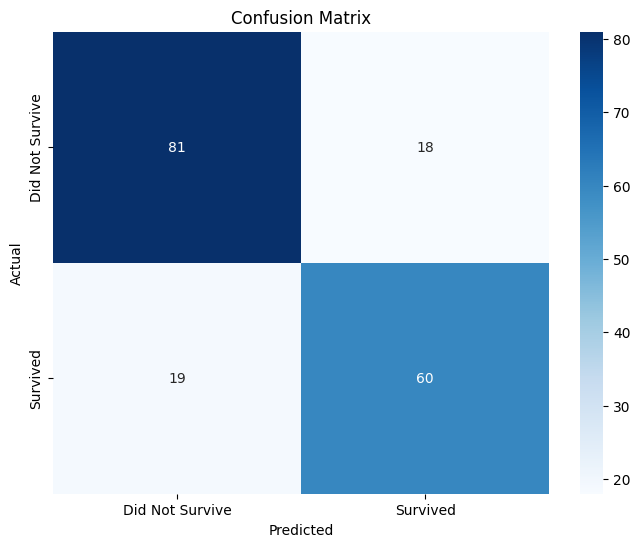

In [471]:
conf_matrix = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [472]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log)
recall = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)

# Create a new DataFrame with the metrics

if 'Logistics Regression' not in all_stats_df['Classifier'].values:
    new_stats_df = pd.DataFrame([{
        'Classifier': 'Logistics Regression',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)
else:
    all_stats_df.loc[all_stats_df['Classifier'] == 'Logistics Regression', ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = [accuracy, precision, recall, f1]

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7921348314606742
Precision: 0.7692307692307693
Recall: 0.759493670886076
F1 Score: 0.7643312101910829


/var/folders/14/9z1c81gx4nz56mqrm1tnqwy80000gn/T/ipykernel_39087/3404408154.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)


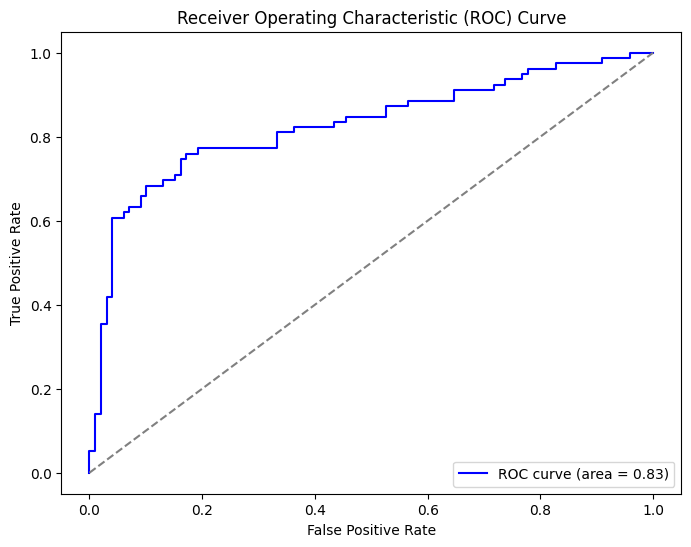

In [473]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Refitted Logistics Regression (With Stepwise Model Selection)

In [474]:
X_1 = train_encoded.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Survived', 'Name'])
X_1['PClass_2 * Sex'] = X_1['Pclass_2'] * X_1['Sex']
X_1['PClass_3 * Sex'] = X_1['Pclass_3'] * X_1['Sex']
y_1 = train_encoded['Survived']

# Perform train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.25, random_state=42)

print(f"X_train_resampled shape: {X_train_1.shape}")
print(f"X_test shape: {X_test_1.shape}")
print(f"y_train shape: {y_train_1.shape}")
print(f"y_test shape: {y_test_1.shape}")

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled_1, y_train_resampled_1 = smote.fit_resample(X_train_1, y_train_1)

# Print the shape of the resampled data
print(f"X_train_resampled shape: {X_train_resampled_1.shape}")
print(f"y_train_resampled shape: {y_train_resampled_1.shape}")

X_train_resampled shape: (534, 11)
X_test shape: (178, 11)
y_train shape: (534,)
y_test shape: (178,)
X_train_resampled shape: (650, 11)
y_train_resampled shape: (650,)


In [475]:
from sklearn.feature_selection import SequentialFeatureSelector

# Initialize the logistic regression model
log_reg_1 = LogisticRegression(max_iter=1000)

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(log_reg_1, n_features_to_select='auto', direction='forward', scoring='recall', cv=5)

# Fit the Sequential Feature Selector to the training data
sfs.fit(X_train_resampled_1, y_train_resampled_1)

# Get the selected features
selected_features = X_train_resampled_1.columns[sfs.get_support()]

print("Selected features:", selected_features)

# Transform the training and test sets
X_train_sfs = sfs.transform(X_train_resampled_1)
X_test_sfs = sfs.transform(X_test_1)

# Fit the logistic regression model on the selected features
log_reg_1.fit(X_train_sfs, y_train_resampled_1)

# Predict on the test set
y_pred_sfs = log_reg_1.predict(X_test_sfs)

# Print classification report
print(classification_report(y_test_1, y_pred_sfs))

Selected features: Index(['Age', 'Parch', 'Pclass_3', 'Embarked_S', 'PClass_3 * Sex'], dtype='object')
              precision    recall  f1-score   support

           0       0.72      0.59      0.64        99
           1       0.58      0.71      0.64        79

    accuracy                           0.64       178
   macro avg       0.65      0.65      0.64       178
weighted avg       0.65      0.64      0.64       178



In [476]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_sfs)
precision = precision_score(y_test, y_pred_sfs)
recall = recall_score(y_test, y_pred_sfs)
f1 = f1_score(y_test, y_pred_sfs)

# Create a new DataFrame with the metrics

if 'Logistics Regression II' not in all_stats_df['Classifier'].values:
    new_stats_df = pd.DataFrame([{
        'Classifier': 'Logistics Regression II',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)
else:
    all_stats_df.loc[all_stats_df['Classifier'] == 'Logistics Regression II', ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = [accuracy, precision, recall, f1]

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.6404494382022472
Precision: 0.5773195876288659
Recall: 0.7088607594936709
F1 Score: 0.6363636363636364


## K-Nearest Neighbours

In [477]:
# Define the parameter grid
param_grid = {'n_neighbors': range(1, 40)}

# Initialize the GridSearchCV with KNeighborsClassifier
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='precision')

# Fit the GridSearchCV to the training data
grid_search_knn.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search_knn.best_params_
best_score = grid_search_knn.best_score_

print(f"Best number of neighbors: {best_params['n_neighbors']}")
print(f"Best cross-validation accuracy: {best_score}")

Best number of neighbors: 2
Best cross-validation accuracy: 0.7656795479769953


In [478]:
grid_predictions_knn = grid_search_knn.predict(X_test) 

# print classification report 
print(classification_report(y_test, grid_predictions_knn)) 

              precision    recall  f1-score   support

           0       0.68      0.78      0.73        99
           1       0.66      0.54      0.60        79

    accuracy                           0.67       178
   macro avg       0.67      0.66      0.66       178
weighted avg       0.67      0.67      0.67       178



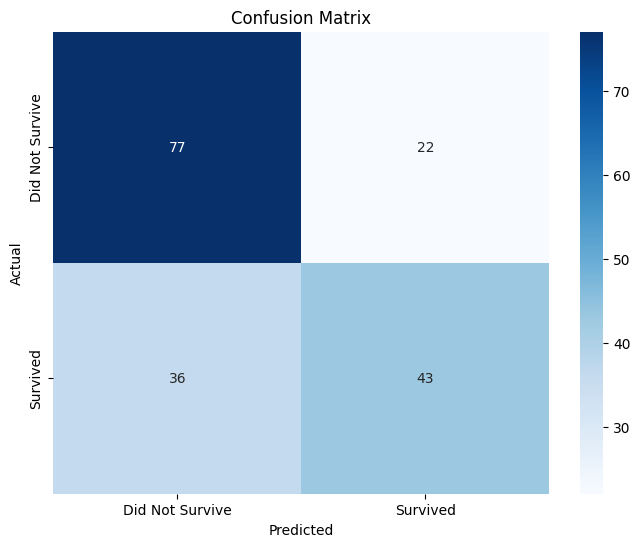

In [479]:
conf_matrix = confusion_matrix(y_test, grid_predictions_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [480]:
# Calculate metrics for KNN
accuracy_knn = accuracy_score(y_test, grid_predictions_knn)
precision_knn = precision_score(y_test, grid_predictions_knn)
recall_knn = recall_score(y_test, grid_predictions_knn)
f1_knn = f1_score(y_test, grid_predictions_knn)

# Create a new DataFrame with the metrics
if 'KNN' not in all_stats_df['Classifier'].values:
    new_stats_df_knn = pd.DataFrame([{
        'Classifier': 'KNN',
        'Accuracy': accuracy_knn,
        'Precision': precision_knn,
        'Recall': recall_knn,
        'F1 Score': f1_knn
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df_knn], ignore_index=True)
else:
    all_stats_df.loc[all_stats_df['Classifier'] == 'KNN', ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = [accuracy_knn, precision_knn, recall_knn, f1_knn]

print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")


Accuracy: 0.6741573033707865
Precision: 0.6615384615384615
Recall: 0.5443037974683544
F1 Score: 0.5972222222222222


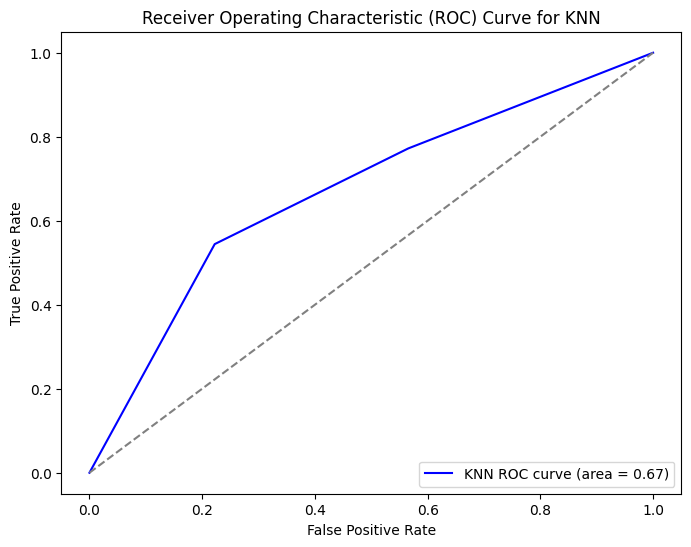

In [481]:
# Compute predicted probabilities for KNN
y_pred_prob_knn = grid_search_knn.predict_proba(X_test)[:, 1]

# Compute ROC curve for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_prob_knn)

# Compute AUC score for KNN
roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

# Plot ROC curve for KNN
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', label=f'KNN ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc='lower right')
plt.show()

## Support Vector Machine + PCA

In [482]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=2)
# Fit PCA on the training data
X_train_resampled_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.fit_transform(X_test)

# Print the explained variance ratio
print(f"Explained variance ratio: {sum(list(pca.explained_variance_ratio_))}")

Explained variance ratio: 0.9995006212855514


In [483]:
# Define the parameter grid for SVM
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear']}

# Initialize the GridSearchCV with SVC
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search_svm.fit(X_train_resampled_pca, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search_svm.best_params_
best_score = grid_search_svm.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")

KeyboardInterrupt: 

In [405]:
grid_predictions_svm = grid_search_svm.predict(X_test_pca) 

# print classification report 
print(classification_report(y_test, grid_predictions_svm)) 

              precision    recall  f1-score   support

           0       0.63      0.84      0.72        99
           1       0.65      0.38      0.48        79

    accuracy                           0.63       178
   macro avg       0.64      0.61      0.60       178
weighted avg       0.64      0.63      0.61       178



In [406]:
# Calculate metrics for SVM
accuracy_svm = accuracy_score(y_test, grid_predictions_svm)
precision_svm = precision_score(y_test, grid_predictions_svm)
recall_svm = recall_score(y_test, grid_predictions_svm)
f1_svm = f1_score(y_test, grid_predictions_svm)

# Create a new DataFrame with the metrics
if 'SVM' not in all_stats_df['Classifier'].values:
    new_stats_df_knn = pd.DataFrame([{
        'Classifier': 'SVM',
        'Accuracy': accuracy_svm,
        'Precision': precision_svm,
        'Recall': recall_svm,
        'F1 Score': f1_svm
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df_knn], ignore_index=True)
else:
    all_stats_df.loc[all_stats_df['Classifier'] == 'SVM', ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = [accuracy_svm, precision_svm, recall_svm, f1_svm]

print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"F1 Score: {f1_svm}")


Accuracy: 0.6348314606741573
Precision: 0.6521739130434783
Recall: 0.379746835443038
F1 Score: 0.48


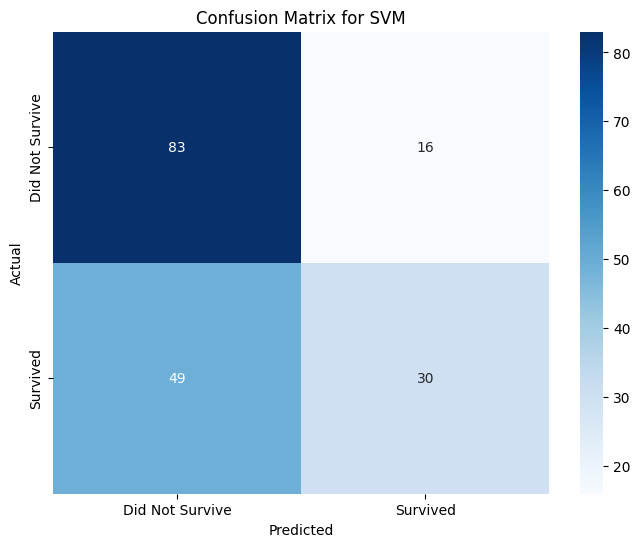

In [407]:
conf_matrix = confusion_matrix(y_test, grid_predictions_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

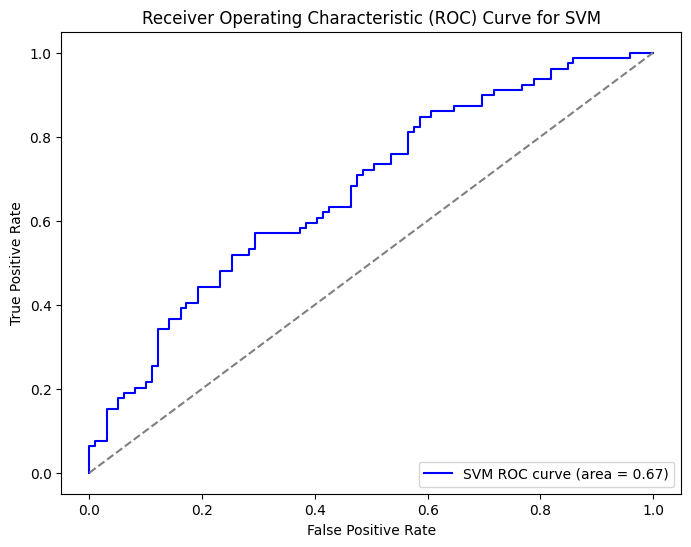

In [ ]:
# Compute predicted probabilities for SVM
y_pred_prob_svm = grid_search_svm.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_prob_svm)

# Compute AUC score for SVM
roc_auc_svm = roc_auc_score(y_test, y_pred_prob_svm)

# Plot ROC curve for SVM
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc='lower right')
plt.show()

## Decision Trees

In [373]:
# Define the parameter grid for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV with DecisionTreeClassifier
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search_dt.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

print(f"Best parameters for Decision Tree: {best_params_dt}")
print(f"Best cross-validation accuracy score for Decision Tree: {best_score_dt}")

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation accuracy score for Decision Tree: 0.7846153846153845


In [374]:
# Predict using the best Decision Tree model
grid_predictions_dt = grid_search_dt.predict(X_test)

# Print classification report
print(classification_report(y_test, grid_predictions_dt))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76        99
           1       0.71      0.70      0.70        79

    accuracy                           0.74       178
   macro avg       0.73      0.73      0.73       178
weighted avg       0.74      0.74      0.74       178



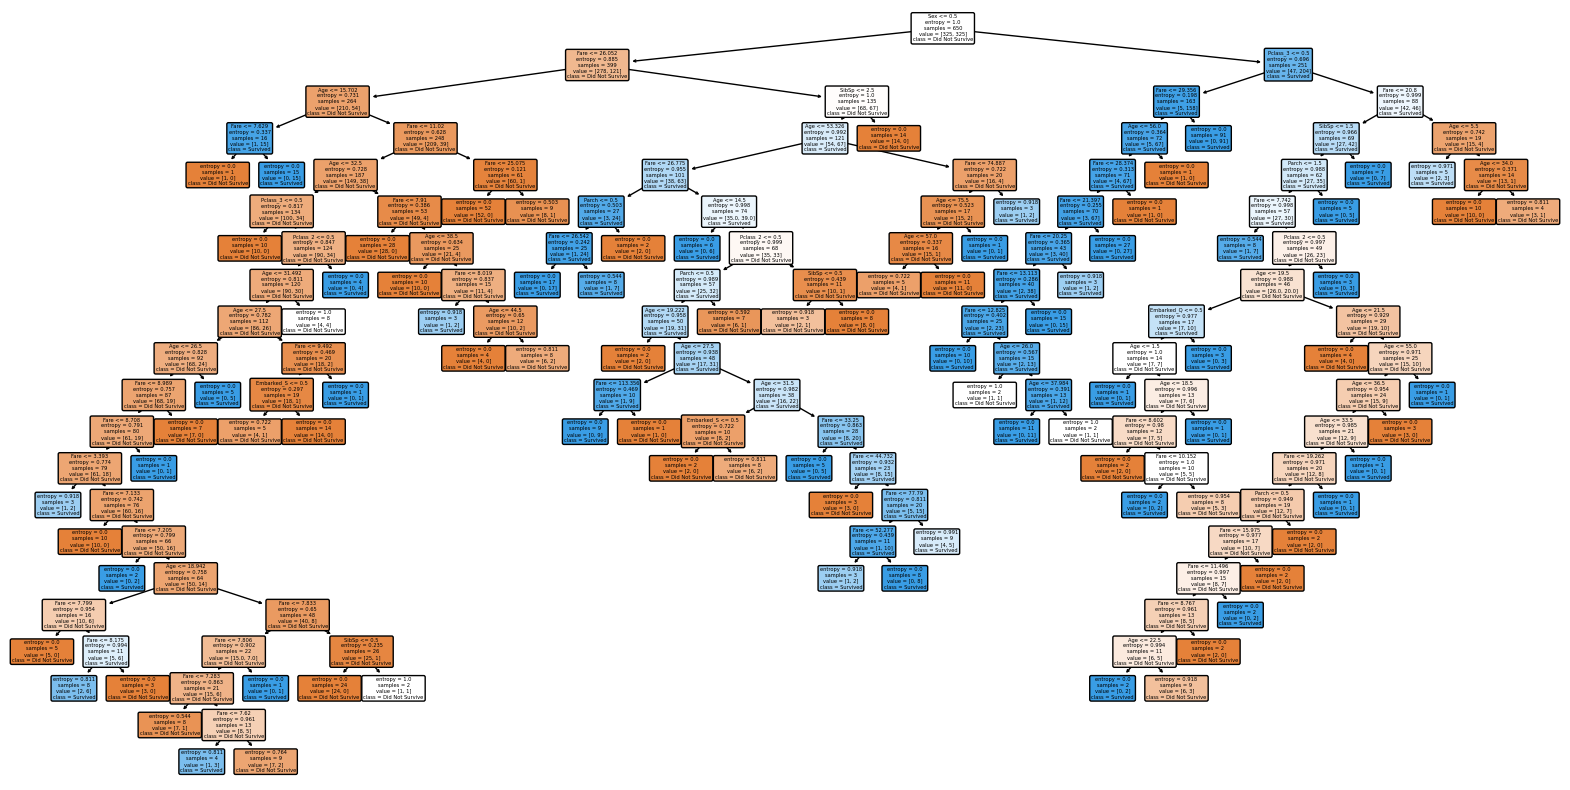

In [375]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(grid_search_dt.best_estimator_, feature_names=X_train_resampled.columns, class_names=['Did Not Survive', 'Survived'], filled=True, rounded=True)
plt.show()

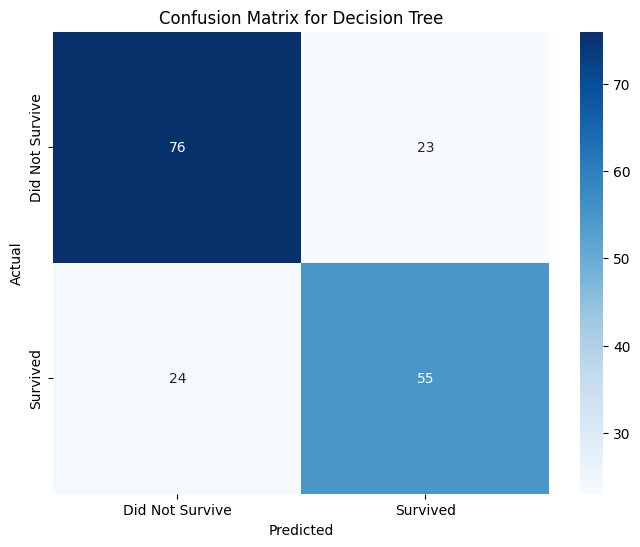

In [376]:
conf_matrix = confusion_matrix(y_test, grid_predictions_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [377]:
# Calculate metrics for Decision Tree
accuracy_dt = accuracy_score(y_test, grid_predictions_dt)
precision_dt = precision_score(y_test, grid_predictions_dt)
recall_dt = recall_score(y_test, grid_predictions_dt)
f1_dt = f1_score(y_test, grid_predictions_dt)

# Create a new DataFrame with the metrics
if 'Decision Tree' not in all_stats_df['Classifier'].values:
    new_stats_df_dt = pd.DataFrame([{
        'Classifier': 'Decision Tree',
        'Accuracy': accuracy_dt,
        'Precision': precision_dt,
        'Recall': recall_dt,
        'F1 Score': f1_dt
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df_dt], ignore_index=True)
else:
    all_stats_df.loc[all_stats_df['Classifier'] == 'Decision Tree', ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = [accuracy_dt, precision_dt, recall_dt, f1_dt]

print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")


Accuracy: 0.7359550561797753
Precision: 0.7051282051282052
Recall: 0.6962025316455697
F1 Score: 0.7006369426751592


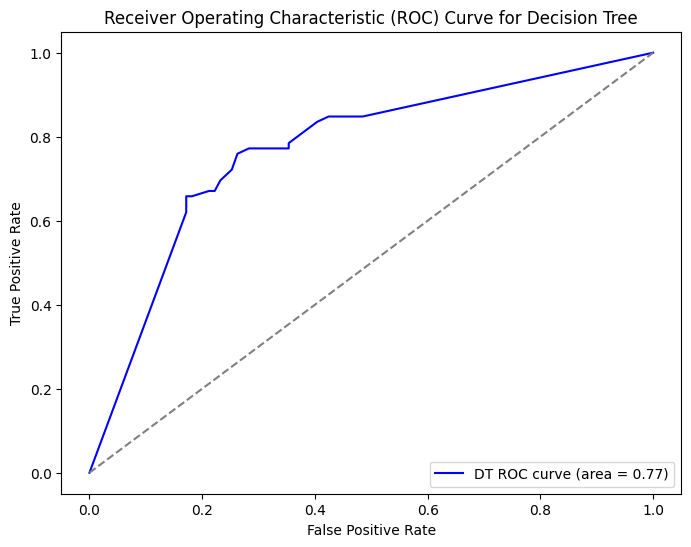

In [378]:
# Compute predicted probabilities for Decision Tree
y_pred_prob_dt = grid_search_dt.predict_proba(X_test)[:, 1]

# Compute ROC curve for Decision Tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_prob_dt)

# Compute AUC score for Decision Tree
roc_auc_dt = roc_auc_score(y_test, y_pred_prob_dt)

# Plot ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', label=f'DT ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

## Random Forest

In [379]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV with RandomForestClassifier
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"Best parameters for Random Forest: {best_params_rf}")
print(f"Best cross-validation accuracy score for Random Forest: {best_score_rf}")

Best parameters for Random Forest: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy score for Random Forest: 0.8292307692307693


In [380]:
# Predict using the best Decision Tree model
grid_prediction_rf = grid_search_rf.predict(X_test)

# Print classification report
print(classification_report(y_test, grid_prediction_rf))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        99
           1       0.79      0.73      0.76        79

    accuracy                           0.80       178
   macro avg       0.80      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178



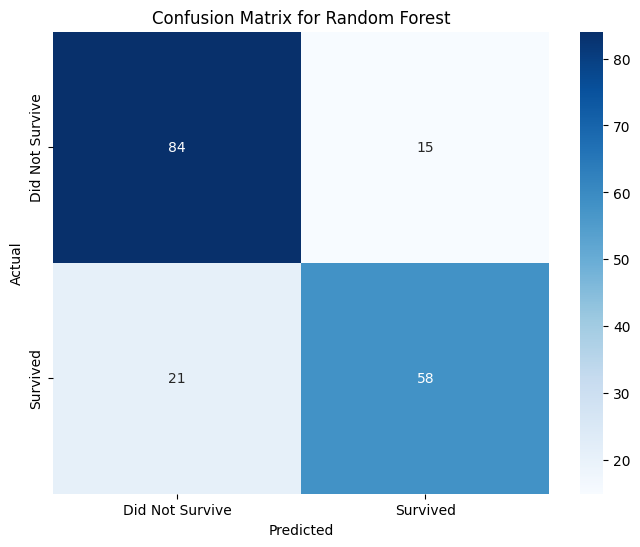

In [381]:
conf_matrix = confusion_matrix(y_test, grid_prediction_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [382]:
# Calculate metrics for Random Forest
accuracy_rf = accuracy_score(y_test, grid_prediction_rf)
precision_rf = precision_score(y_test, grid_prediction_rf)
recall_rf = recall_score(y_test, grid_prediction_rf)
f1_rf = f1_score(y_test, grid_prediction_rf)

# Create a new DataFrame with the metrics
if 'Random Forest' not in all_stats_df['Classifier'].values:
    new_stats_df_rf = pd.DataFrame([{
        'Classifier': 'Random Forest',
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1 Score': f1_rf
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df_rf], ignore_index=True)
else:
    all_stats_df.loc[all_stats_df['Classifier'] == 'Random Forest', ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = [accuracy_rf, precision_rf, recall_rf, f1_rf]

print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

Accuracy: 0.797752808988764
Precision: 0.7945205479452054
Recall: 0.7341772151898734
F1 Score: 0.7631578947368421


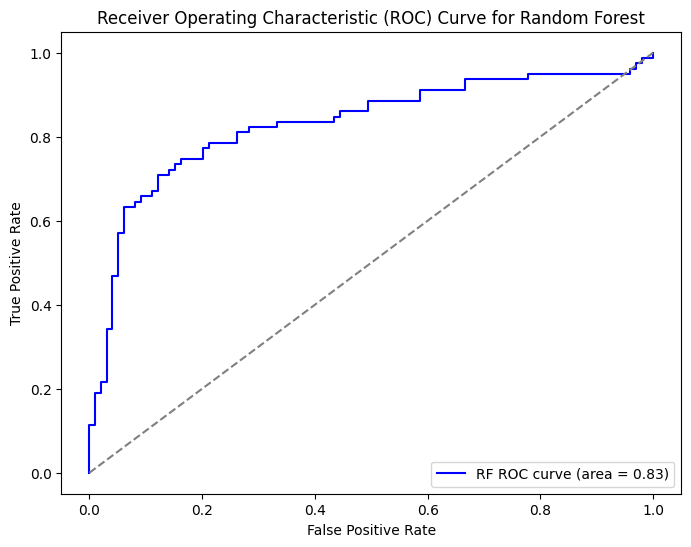

In [383]:
# Compute predicted probabilities for Random Forest
y_pred_prob_rf = grid_search_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)

# Compute AUC score for Random Forest
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Plot ROC curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'RF ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

## Gradient Boosting Machines

In [384]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid for Gradient Boosting
param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV with GradientBoostingClassifier
grid_search_gbm = GridSearchCV(GradientBoostingClassifier(), param_grid_gbm, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search_gbm.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params_gbm = grid_search_gbm.best_params_
best_score_gbm = grid_search_gbm.best_score_

print(f"Best parameters for Gradient Boosting: {best_params_gbm}")
print(f"Best cross-validation accuracy score for Gradient Boosting: {best_score_gbm}")

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy score for Gradient Boosting: 0.8246153846153845


In [385]:
# Predict using the best Decision Tree model
grid_prediction_gbm = grid_search_gbm.predict(X_test)

# Print classification report
print(classification_report(y_test,  grid_prediction_gbm))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        99
           1       0.76      0.71      0.73        79

    accuracy                           0.77       178
   macro avg       0.77      0.76      0.77       178
weighted avg       0.77      0.77      0.77       178



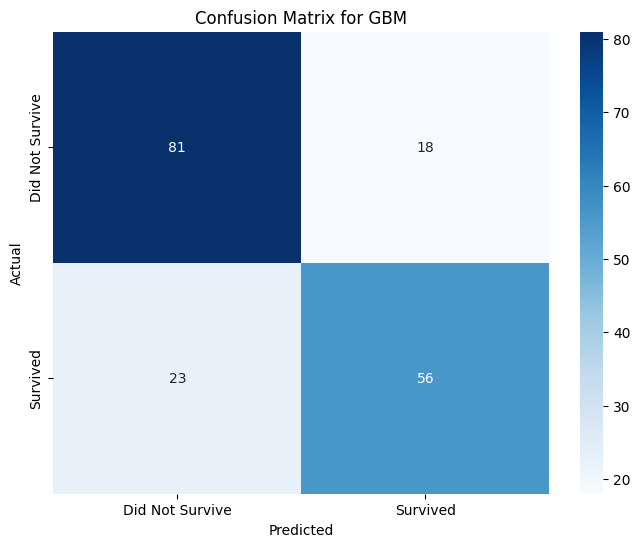

In [386]:
conf_matrix = confusion_matrix(y_test, grid_prediction_gbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for GBM')
plt.show()

In [387]:
# Calculate metrics for Random Forest
accuracy_gbm = accuracy_score(y_test, grid_prediction_gbm)
precision_gbm = precision_score(y_test, grid_prediction_gbm)
recall_gbm = recall_score(y_test, grid_prediction_gbm)
f1_gbm = f1_score(y_test, grid_prediction_gbm)

# Create a new DataFrame with the metrics
if 'GBM' not in all_stats_df['Classifier'].values:
    new_stats_df_rf = pd.DataFrame([{
        'Classifier': 'GBM',
        'Accuracy': accuracy_gbm,
        'Precision': precision_gbm,
        'Recall': recall_gbm,
        'F1 Score': f1_gbm
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df_rf], ignore_index=True)
else:
    all_stats_df.loc[all_stats_df['Classifier'] == 'GBM', ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = [accuracy_rf, precision_rf, recall_rf, f1_rf]

print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

Accuracy: 0.797752808988764
Precision: 0.7945205479452054
Recall: 0.7341772151898734
F1 Score: 0.7631578947368421


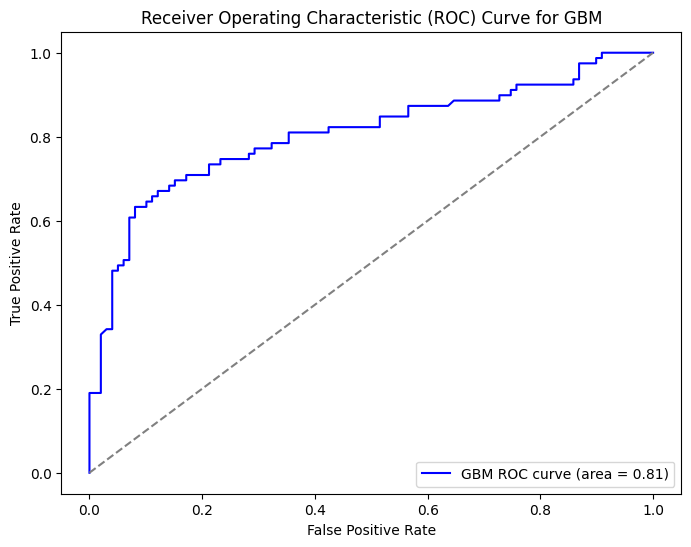

In [388]:
# Compute predicted probabilities for GBM
y_pred_prob_gbm = grid_search_gbm.predict_proba(X_test)[:, 1]

# Compute ROC curve for GBM
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test, y_pred_prob_gbm)

# Compute AUC score for GBM
roc_auc_gbm = roc_auc_score(y_test, y_pred_prob_gbm)

# Plot ROC curve for GBM
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm, tpr_gbm, color='blue', label=f'GBM ROC curve (area = {roc_auc_gbm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for GBM')
plt.legend(loc='lower right')
plt.show()

## AdaBoost

In [389]:
from sklearn.ensemble import AdaBoostClassifier

# Define the parameter grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# Initialize the GridSearchCV with AdaBoostClassifier
grid_search_ada = GridSearchCV(AdaBoostClassifier(), param_grid_ada, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search_ada.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params_ada = grid_search_ada.best_params_
best_score_ada = grid_search_ada.best_score_

print(f"Best parameters for AdaBoost: {best_params_ada}")
print(f"Best cross-validation accuracy score for AdaBoost: {best_score_ada}")

# Predict using the best AdaBoost model
grid_predictions_ada = grid_search_ada.predict(X_test)

# Print classification report
print(classification_report(y_test, grid_predictions_ada))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 200}
Best cross-validation accuracy score for AdaBoost: 0.7769230769230768
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        99
           1       0.72      0.78      0.75        79

    accuracy                           0.77       178
   macro avg       0.77      0.77      0.77       178
weighted avg       0.77      0.77      0.77       178



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


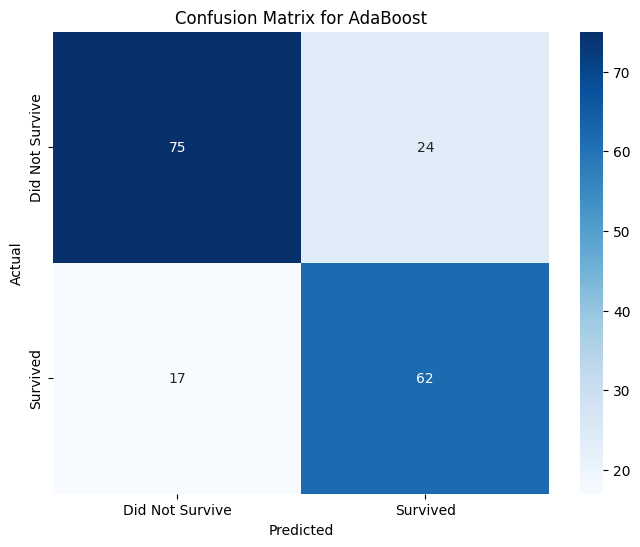

In [390]:
conf_matrix = confusion_matrix(y_test, grid_predictions_ada)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost')
plt.show()

In [391]:
# Calculate metrics for AdaBoost
accuracy_ada = accuracy_score(y_test, grid_predictions_ada)
precision_ada = precision_score(y_test, grid_predictions_ada)
recall_ada = recall_score(y_test, grid_predictions_ada)
f1_ada = f1_score(y_test, grid_predictions_ada)

# Create a new DataFrame with the metrics
if 'AdaBoost' not in all_stats_df['Classifier'].values:
    new_stats_df_ada = pd.DataFrame([{
        'Classifier': 'AdaBoost',
        'Accuracy': accuracy_ada,
        'Precision': precision_ada,
        'Recall': recall_ada,
        'F1 Score': f1_ada
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df_ada], ignore_index=True)
else:
    all_stats_df.loc[all_stats_df['Classifier'] == 'AdaBoost', ['Accuracy', 'Precision', 'Recall', 'F1 Score']] = [accuracy_ada, precision_ada, recall_ada, f1_ada]

print(f"Accuracy: {accuracy_ada}")
print(f"Precision: {precision_ada}")
print(f"Recall: {recall_ada}")
print(f"F1 Score: {f1_ada}")

Accuracy: 0.7696629213483146
Precision: 0.7209302325581395
Recall: 0.7848101265822784
F1 Score: 0.7515151515151515


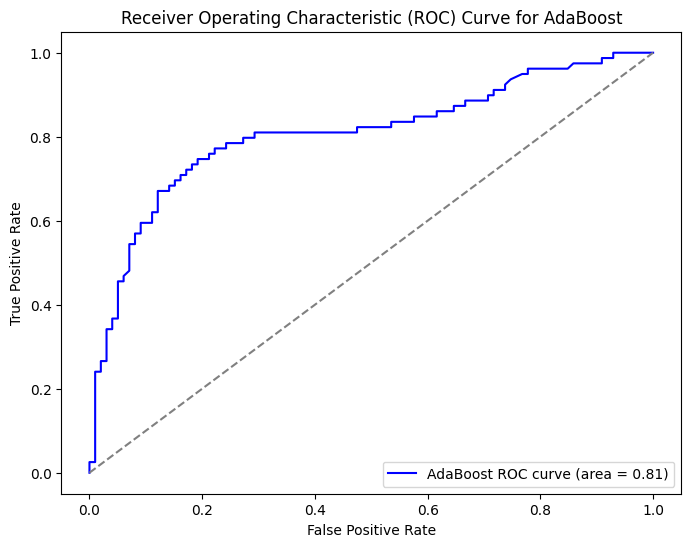

In [392]:
# Compute predicted probabilities for AdaBoost
y_pred_prob_ada = grid_search_ada.predict_proba(X_test)[:, 1]

# Compute ROC curve for AdaBoost
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_prob_ada)

# Compute AUC score for AdaBoost
roc_auc_ada = roc_auc_score(y_test, y_pred_prob_ada)

# Plot ROC curve for AdaBoost
plt.figure(figsize=(8, 6))
plt.plot(fpr_ada, tpr_ada, color='blue', label=f'AdaBoost ROC curve (area = {roc_auc_ada:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for AdaBoost')
plt.legend(loc='lower right')
plt.show()

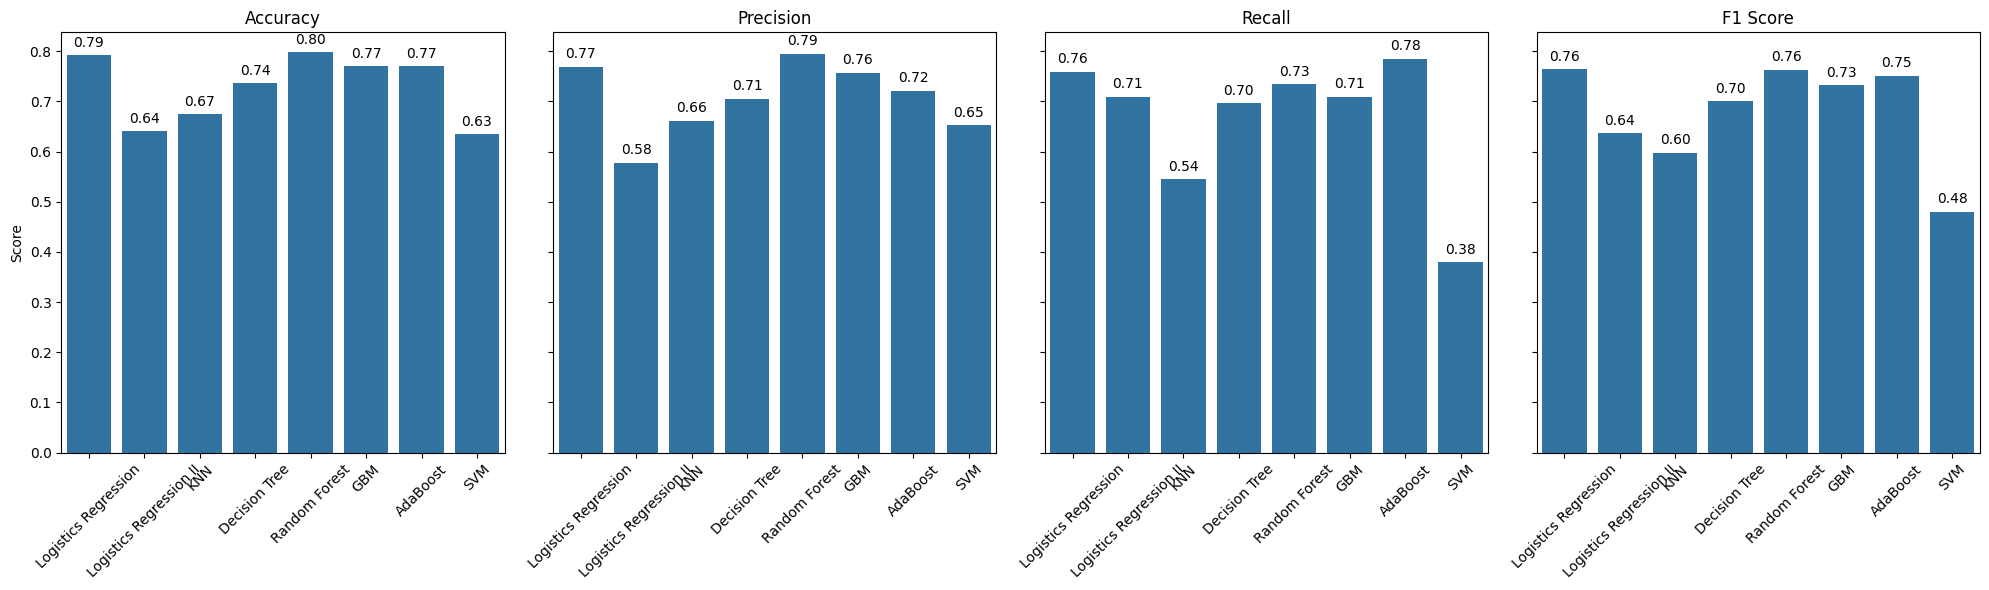

In [ ]:
# Create separate bar plots for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(ax=axes[i], x='Classifier', y=metric, data=all_stats_df)
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Score')
    axes[i].set_xlabel('')
    for p in axes[i].patches:
        axes[i].annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

plt.tight_layout()
plt.show()

## Final Ensemble Model (Random Forest + AdaBoost with Logistics Regression Final Classifier)

In [484]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base classifiers
base_classifiers = [
    ('rf', grid_search_rf),
    ('ada', grid_search_ada)
]

# Define final classifier
final_classifier = LogisticRegression(max_iter=100)

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=final_classifier,
    cv=5
)

# Fit the stacking classifier on the  training data
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_stacking = stacking_clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_stacking))

# Calculate metrics for Stacking Classifier
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)

print(f"Accuracy: {accuracy_stacking}")
print(f"Precision: {precision_stacking}")
print(f"Recall: {recall_stacking}")
print(f"F1 Score: {f1_stacking}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.77      0.73      0.75        79

    accuracy                           0.79       178
   macro avg       0.78      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178

Accuracy: 0.7865168539325843
Precision: 0.7733333333333333
Recall: 0.7341772151898734
F1 Score: 0.7532467532467533


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


## Prediction

In [495]:
X_final = test_encoded.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Name'])
X_final['Fare'].fillna(0, inplace=True)

final_prediction = pd.DataFrame({'PassengerId': test_encoded['PassengerId'], 'Survived': grid_search_rf.predict(X_final)})

final_prediction.head()

/var/folders/14/9z1c81gx4nz56mqrm1tnqwy80000gn/T/ipykernel_39087/4058339796.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_final['Fare'].fillna(0, inplace=True)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [496]:
final_prediction.to_csv("Final_Prediction.csv", index=False)